# Traffic Flow Analysis

## Problem Statement :
Using the historic data from traffic camera (and weather stations), create a ML model to forecast traffic at a given future date-time. 

## Proposed Solution Overview :
I have taken the following steps to tackle the above problem.
1. **Data Collection** : Collected/crawled traffic camera and data from public APIs (api.data.gov.sg). I have used camera id 1705 (lat: 1.37592502246884 , lon: 103.858798593508) as a source of image data and sensor id = S43 (lat: 1.3399, lon: 103.8878 ) as a source of air-temperature and rainfall data. 
The duration of data is last ~65 days, one datapoint collected every 6 minutes (the minimum time difference for image API to return a new image). This resulted in 12895 images (10% of the time, the camera didn't return an image) and 15000 datapoints from S43 sensor. To combine the dataset from both sensors, I have considered common datapoints between both sensors. So, this analysis considers a total of 12895 datapoints. 


2. **Object Detection** : I have used the collected image dataset and identified all the objects (e.g., car, bus, truck, motorbike, person) that could be present on the highway. Using pre-trained YOLOv3 (darknet -- https://pjreddie.com/darknet/ ), I count objects present in each image frame and store this information in a text file (indexed by the image timestamp). 



3. **Data Preprocessing** : I then preprocess the dataset using: 
    - Merge the rainfall, air-temperature and object detection data as obtained in previous step. A total of 12895 datapoints are generated for further analysis. 
    - A few derived columns (from timestamp) are added. This came from an observation of "periodic/seasonal" nature of plot  of detected objects vs timestamp.
    - The datapoints are checked for NaN numbers and corresponding datapoints are dropped if NaN is found. 
 
    - All columns are normalized (using Min-Max scaling). 
    
    

4. **Model Fitting** : Lastly, I fit a few regression models on the final dataset and compare their performance.


**The github repository containing the code is available to clone at : https://github.com/amit-smu/traffic_flow_analysis**

## Solution Details
1. **Data Collection** : To gather data from public APIs, I have created data crawler scripts (for each data type). These scripts are located in : 
src/air_temp_crawler.py, src/traffic_data_crawler.py, src/rainfall_crawler.py

    **traffic_data_crawler.py** 

    Images from the traffic camera are fetched and stored in **dataset/cam_1705** folder of github repo. 


In [ ]:
import requests
import json
from datetime import datetime as datetime
from datetime import timedelta
import urllib.request as req

if __name__ == "__main__":
    INTERVAL = 6  # minutes
    BASE_URL = "https://api.data.gov.sg/v1/transport/traffic-images"
    OUT_DIR = "../dataset"
    PARAMS = {
        "date_time": ""
    }
    CAMERA_ID = "1705"  # corresponding to a specific latitude and longitude
    epoch = "2016-07-01-08:00:00"

    # Adding information about user agent
    opener = req.build_opener()
    opener.addheaders = [('User-Agent',
                          'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
    req.install_opener(opener)

    epoch = datetime.strptime(epoch, "%Y-%m-%d-%H:%M:%S")
    delta = timedelta(minutes=INTERVAL)
    new_dt = epoch

    today = datetime.now()
    while new_dt <= today:
        # print(new_dt)
        new_dt_fmt = datetime.strftime(new_dt, "%Y-%m-%dT%H:%M:%S")
        PARAMS["date_time"] = new_dt_fmt

        response = requests.get(BASE_URL, params=PARAMS)
        res_txt = response.text
        res_json = json.loads(res_txt)

        cameras = res_json["items"][0]["cameras"]
        for cam in cameras:
            if cam["camera_id"] in [CAMERA_ID]:
                # cam_dump = json.dumps(cam, indent=2)
                # print(cam_dump)
                filename = "{}/cam_{}/{}.jpg".format(OUT_DIR, cam["camera_id"],
                                                     new_dt_fmt.replace(":", "-").replace("T", "-"))
                print(filename)
                req.urlretrieve(cam['image'], filename)
                # break

        new_dt = new_dt + delta


   
   
   **air_temp_crawler.py**

    The air temperature data is crawled and stored in **dataset/air_temp_S43** folder. 

In [ ]:
import requests
import json
from datetime import datetime as datetime
from datetime import timedelta
import urllib.request as req

if __name__ == "__main__":
    INTERVAL = 6  # minutes
    BASE_URL = "https://api.data.gov.sg/v1/environment/air-temperature"
    PARAMS = {
        "date_time": ""
    }
    STATION_ID = "S43"  # corresponding to the given latitude and longitude
    OUT_FILENAME = "../dataset/air_temp_{}/air_temp_data.txt".format(STATION_ID)
    epoch = "2021-07-01-07:00:00"

    # Adding information about user agent
    opener = req.build_opener()
    opener.addheaders = [('User-Agent',
                          'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
    req.install_opener(opener)

    epoch = datetime.strptime(epoch, "%Y-%m-%d-%H:%M:%S")
    delta = timedelta(minutes=INTERVAL)
    new_dt = epoch

    today = datetime.now()

    with open(OUT_FILENAME, 'w') as outfile:
        outfile.write("timestamp,sensor_id,temperature\n")
        while new_dt <= today:
            # print(new_dt)
            new_dt_fmt = datetime.strftime(new_dt, "%Y-%m-%dT%H:%M:%S")
            print(new_dt_fmt)
            PARAMS["date_time"] = new_dt_fmt

            response = requests.get(BASE_URL, params=PARAMS)
            res_txt = response.text
            res_json = json.loads(res_txt)

            readings = res_json["items"][0]["readings"]
            for reading in readings:
                if reading["station_id"] in ["S43"]:
                    outfile.write("{},{},{}\n".format(new_dt_fmt.replace(":", "-").replace("T", "-"), STATION_ID,
                                                      reading["value"]))
                    outfile.flush()
            new_dt = new_dt + delta



**rainfall_crawler.py**

Data stored in **dataset/rainfall_S43** folder.

In [ ]:
import requests
import json
from datetime import datetime as datetime
from datetime import timedelta
import urllib.request as req

if __name__ == "__main__":
    INTERVAL = 6  # minutes
    BASE_URL = "https://api.data.gov.sg/v1/environment/rainfall"
    PARAMS = {
        "date_time": ""
    }
    STATION_ID = "S43"  # corresponding to the given latitude and longitude
    OUT_FILENAME = "../dataset/rainfall_{}/rainfall_data.txt".format(STATION_ID)
    epoch = "2021-07-01-07:00:00"

    # Adding information about user agent
    opener = req.build_opener()
    opener.addheaders = [('User-Agent',
                          'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
    req.install_opener(opener)

    epoch = datetime.strptime(epoch, "%Y-%m-%d-%H:%M:%S")
    delta = timedelta(minutes=INTERVAL)
    new_dt = epoch

    today = datetime.now()

    with open(OUT_FILENAME, 'w') as outfile:
        outfile.write("timestamp,sensor_id,rainfall\n")
        while new_dt <= today:
            # print(new_dt)
            new_dt_fmt = datetime.strftime(new_dt, "%Y-%m-%dT%H:%M:%S")
            print(new_dt_fmt)
            PARAMS["date_time"] = new_dt_fmt

            response = requests.get(BASE_URL, params=PARAMS)
            res_txt = response.text
            res_json = json.loads(res_txt)

            readings = res_json["items"][0]["readings"]
            for reading in readings:
                if reading["station_id"] in ["S43"]:
                    outfile.write("{},{},{}\n".format(new_dt_fmt.replace(":", "-").replace("T", "-"), STATION_ID,
                                                      reading["value"]))
                    outfile.flush()
            new_dt = new_dt + delta


2. **Object Detection** :

This dataset is one of the most-important component of traffic-prediction problem. Given a set of camera images, there could be multiple ways to get the traffic images e.g., edge/contour detection techniques. I chose to use an object detector (YOLOv3 taken off-the-shelf from https://pjreddie.com/darknet/) because DNNs are state-of-the-art for object detection and have already outperformed the traditional ML algorithms for object detection. Also, object detection is done only once, during the training phase, for the whole dataset and never used for test phase. 

The results obtained from the detector are quite impressive. Below images show two examples of this during day time and night time. 

Since, the COCO dataset, used for pre-training the YOLOv3 model, already has objects like car, motorbike, bus, truck etc., so I didn't feel the need to re-train the model on this dataset. If we choose to re-train it on the traffic dataset, the accurcy could be improved further. Due to the lack of ground-truth on the traffic dataset, it is not possible to quantify the object detection accuracy here. 


**Note** -- The code for the object detection is not included in the repository because it is simply a fork of the official repository and executed on a GPU.



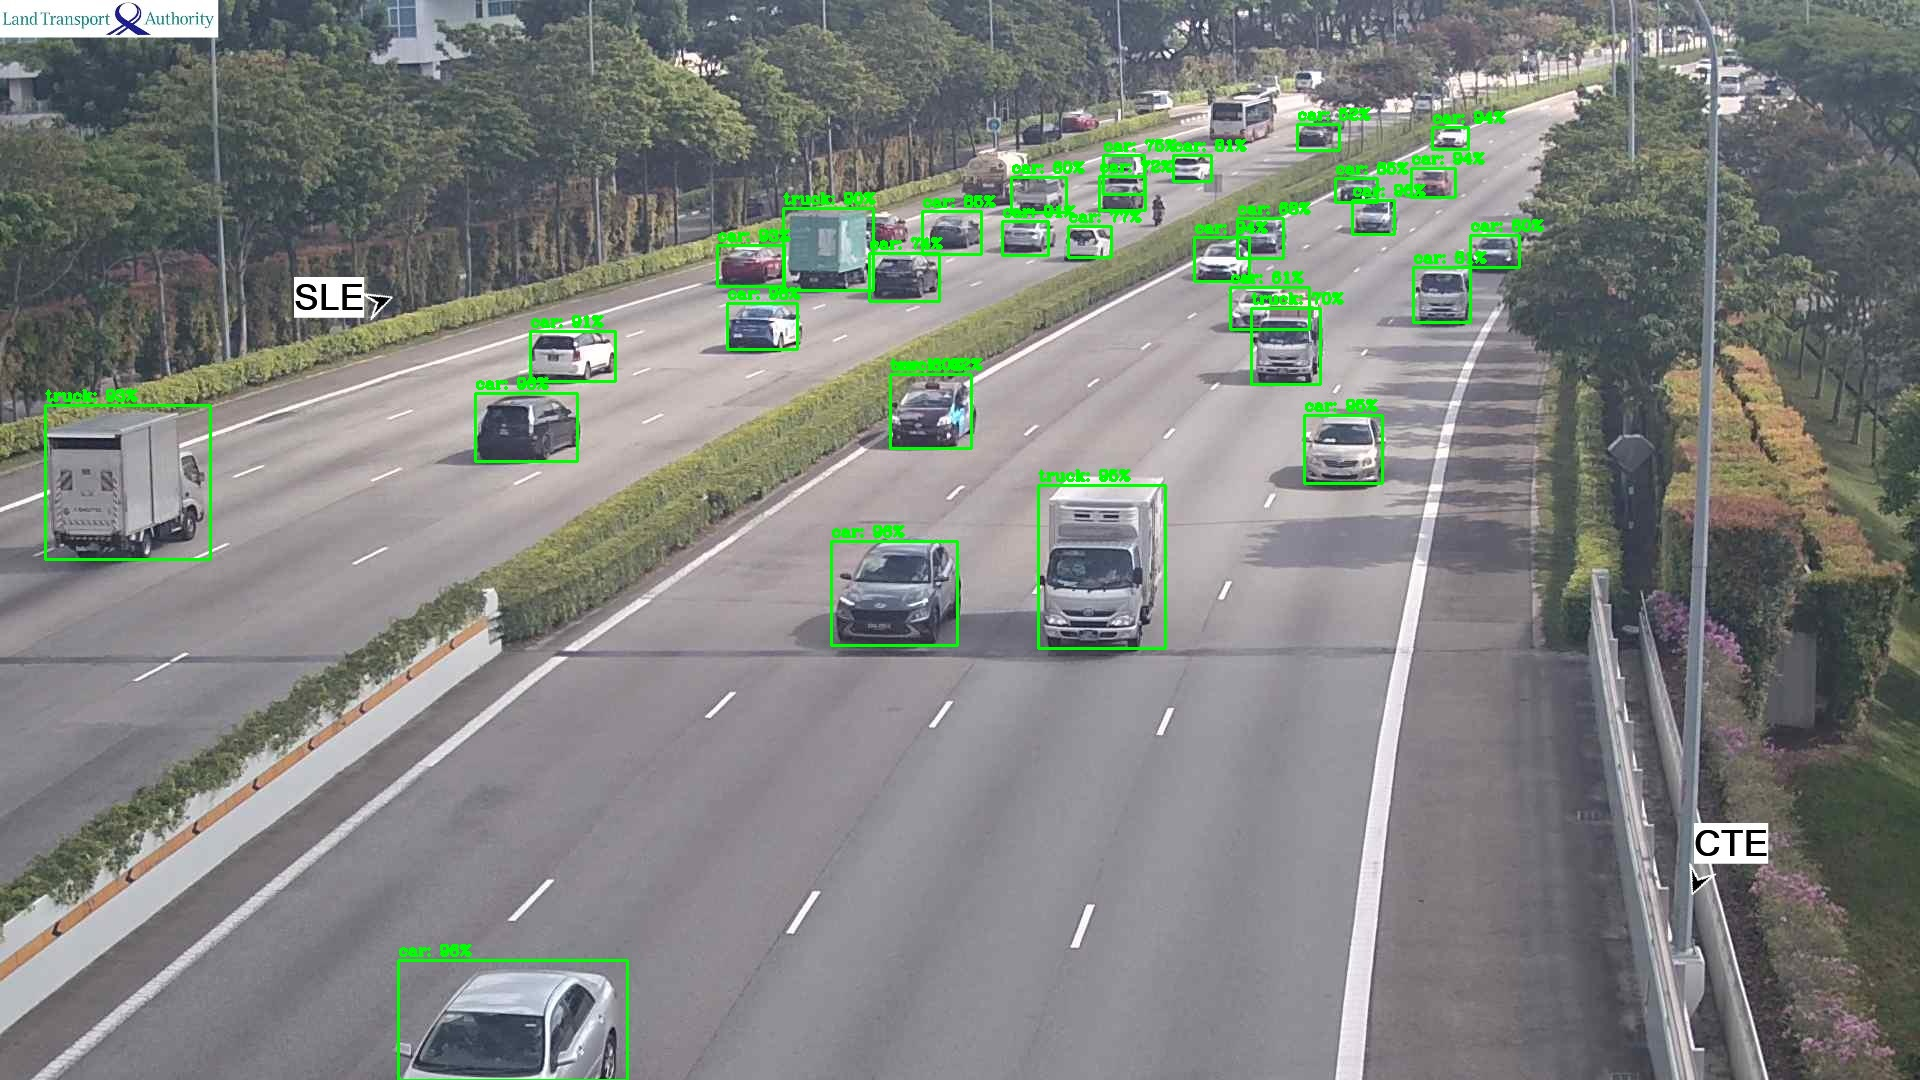

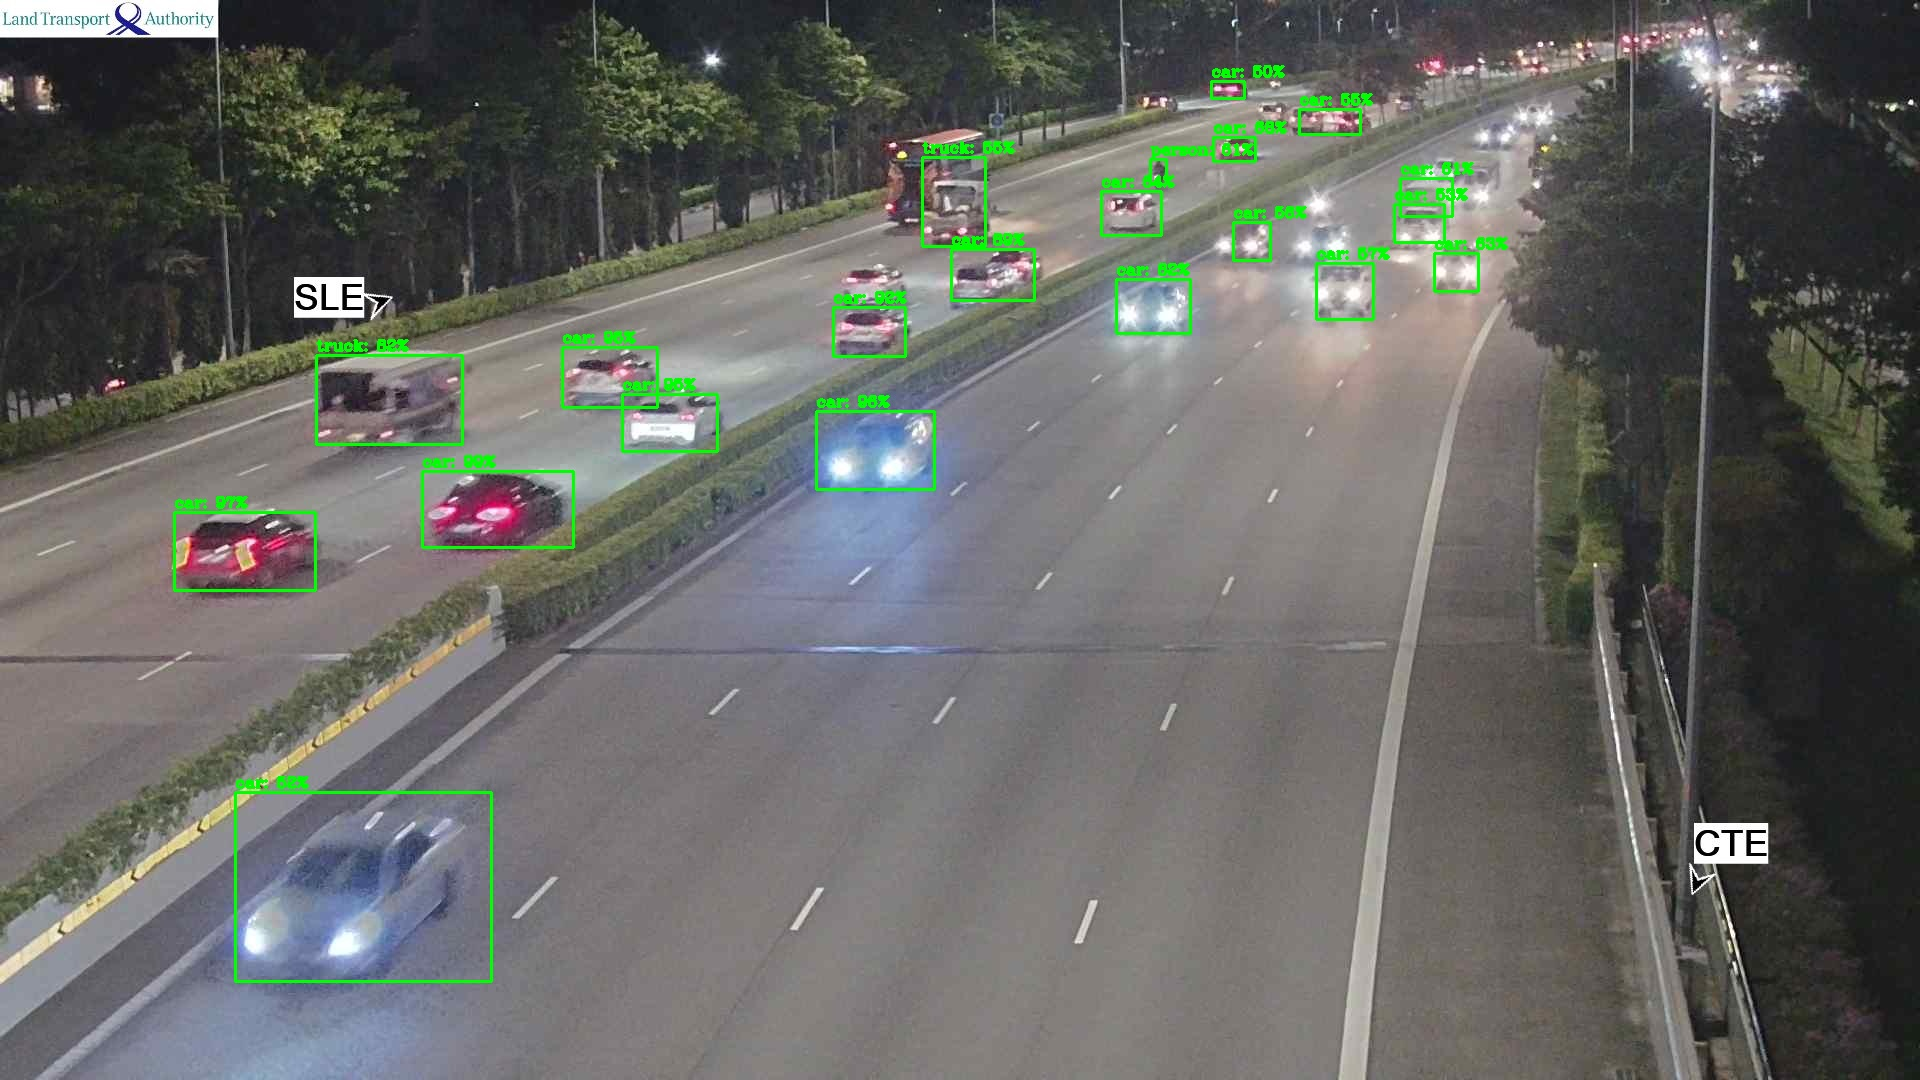

3. **Data Processing & Model Fitting** :

In this step, first I merge the dataset from all the three sensors i.e., object detection data from YOLOv3, air-temperature and rainfall data. 

The complete code for this step can be found in **src/data_processor.py** folder.

Code snippets for individual steps is included below.



 - **Data Merge** --

In [ ]:
    # read all the crawled data
    traffic_df = pd.read_csv(TRAFFIC_FILE)
    temperature_df = pd.read_csv(TEMPERATURE_FILE)
    rainfall_df = pd.read_csv(RAINFALL_FILE)

    df = pd.merge(temperature_df, rainfall_df, on="timestamp")
    df = pd.merge(df, traffic_df, on="timestamp")
    print(df)


The resulting dataset looks like as shown below.

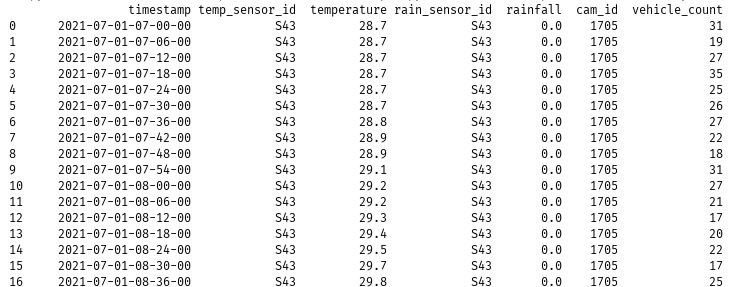

 - **Derived attributes** --

    Next, I plot the number of vehicles detected in an image vs the timestamp of that image. 


In [ ]:
    ax = df.plot(kind="line", y="vehicle_count")
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Number of Vehicles Detected")
    plt.show()

Image below shows how vehicle_count value varies with timestamp. 
It can be seen that there is a pattern that repeats everyday. This pattern seem to be depending on the time of the day and day of week. So, I chose to add these attributes to the dataset.

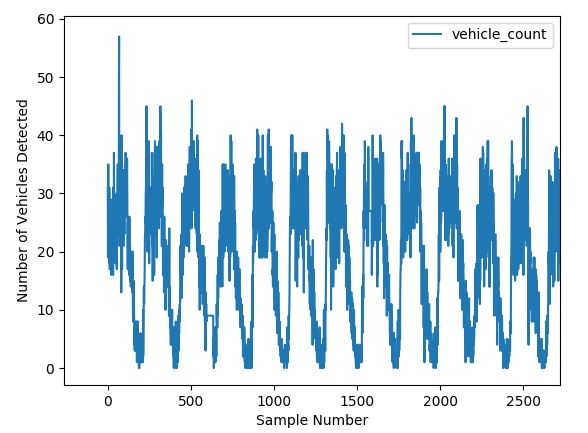

Derived attributes are added by following code snippet. 

In [ ]:
    # add derived attributes to dataframe
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d-%H-%M-%S")
    # add weekend or weekday attribute
    df['day_of_week'] = df['timestamp'].dt.weekday
    df['weekend'] = df['day_of_week'].apply(lambda x: 1.0 if x > 4 else 0)  # 0 - Monday, 6- Sunday
    # add "morning/noon/evening/night" attribute
    df['time'] = df['timestamp'].dt.time
    # df['day_phase'] = df['time'].apply(get_day_phase)
    df['hour'] = df['time'].apply(lambda x: x.hour)

 - **Moving Window Average, NaN drop & Normalization** 
     
     I used below code snippet to achieve these. 

In [ ]:
    # moving average to smooth vehicle_count data.
    df['vehicle_count'] = df['vehicle_count'].rolling(window=MOVING_AVG_WINDOW).mean()

    # dropp NaN values from the dataset
    df = df.dropna()
    df['vehicle_count'] = df['vehicle_count'].astype("int32")

    # apply min-max normalization
    df['rain_norm'] = (df['rainfall'] - df['rainfall'].min()) / (df['rainfall'].max() - df['rainfall'].min())
    df['temp_norm'] = (df['temperature'] - df['temperature'].min()) / (
            df['temperature'].max() - df['temperature'].min())
    df['dow_norm'] = (df['day_of_week'] - df['day_of_week'].min()) / (
            df['day_of_week'].max() - df['day_of_week'].min())
    df['hour_norm'] = (df['hour'] - df['hour'].min()) / (
            df['hour'].max() - df['hour'].min())

4. **Model Fitting & Performance Evaluation**

    Lastly, I fit various regression models and compare their performance. The total dataset is split into 80:20 ratio for training and testing phases.


  **Note** -- Since we are interested in forecasting and not only in regression, so I have chosen the first 80% of the dataset (ordered by timestamp) as training and then the remaining 20% dataset (representing future time) is used for testing.

    Corresponding code snippets are shown below.


In [ ]:

def test_baseline_model(train_df, Y_train, Y_test):
    """
    always returns the mean of the vehicle count from training data
    :param train_df:
    :param Y_train:
    :param Y_test:
    :return:
    """
    veh_count_mean = train_df['vehicle_count'].mean()

    # estimate performance of model
    y_pred_training = np.full(shape=(len(Y_train), 1), fill_value=veh_count_mean)  # always returns the mean
    y_pred_test = np.full(shape=(len(Y_test), 1), fill_value=veh_count_mean)  # always returns the mean

    r2_score_training = r2_score(y_true=Y_train, y_pred=y_pred_training)
    r2_score_test = r2_score(y_true=Y_test, y_pred=y_pred_test)
    rmse_training = np.sqrt(mean_squared_error(y_true=Y_train, y_pred=y_pred_training))
    rmse_test = np.sqrt(mean_squared_error(y_true=Y_test, y_pred=y_pred_test))
    print("********* Baseline Model Performance ******\n")
    print("Training Evaluation : R2-Score: {}, RMSE : {}\n".format(r2_score_training, rmse_training))
    print("Test Evaluation : R2-Score: {}, RMSE : {}\n".format(r2_score_test, rmse_test))

def fit_models(dframe):
    """
    # method to fit ML model(s) on the provided dataframe object
    :param dframe:
    :return:
    """
    print(dframe)
    # split data (80-20) into training and testing set
    training_len = int(len(dframe) * 0.80)
    train_df = dframe.iloc[:training_len]
    test_df = dframe.iloc[training_len:].reset_index()

    X_train = (train_df[['hour_norm', 'weekend']]).values
    Y_train = (train_df[['vehicle_count']]).values
    X_test = (test_df[['hour_norm', 'weekend']]).values
    Y_test = (test_df[['vehicle_count']]).values

    # polynomial feature transformation
    poly_features = PolynomialFeatures(degree=DEGREE, interaction_only=False)
    X_train_poly = poly_features.fit_transform(X=X_train)
    X_test_poly = poly_features.transform(X=X_test)

    # Baseline model -- returns mean of the data
    test_baseline_model(train_df, Y_train, Y_test)

    # traing models here
    model = LinearRegression()  # Linear
    # model = Ridge(alpha=0.5)
    # model = SVR()
    # model = RandomForestRegressor()
    # model = GradientBoostingRegressor()

    model.fit(X=X_train_poly, y=Y_train)
    # training evaluation
    r_score_train = model.score(X=X_train_poly, y=Y_train)
    rmse_train = np.sqrt(mean_squared_error(y_true=Y_train, y_pred=model.predict(X_train_poly)))

    # display results
    print("************ Proposed Model Performance *********** \n")
    print("Training Evaluation: R2-Score : {}, RMSE : {}\n".format(r_score_train, rmse_train))

    # test data evaluation
    r_score_test = model.score(X=X_test_poly, y=Y_test)
    rmse_test = np.sqrt(mean_squared_error(y_true=Y_test, y_pred=model.predict(X_test_poly)))
    print("Test Evaluation: R2-Score : {}, RMSE : {}\n".format(r_score_test, rmse_test))
    

df_sub = df[['timestamp', 'vehicle_count', 'hour_norm', 'weekend', 'rain_norm', 'temp_norm']]
fit_models(df_sub)



 **Performance Evaluation** :
 
 The accuracy metrices used for evaluation are R2 Score and RMSE (Root Mean Squared Error) values. RMSE value here represents error in terms of number of vehicles.
 
  1. **Baseline model** : 
    This model **always returns the mean value** of all the vehicle_count datapoints as seen in training dataset. So, the output is always same and doesn't depend on any of the independent variables. 
      
      
    The R2 score and RMSE values for this model are as following:

    **Training Dataset Accuracy**

    R2-Score -- 0.0 |  RMSE -- 10.5 


    **Test Dataset Accuracy**

    R2-Score -- 0.0 |  RMSE -- 11
     
     


     
  2. **Linear Regression** :
      Next, I fit a multi-variate linear regression model with polynomial features of degree varying from 1 to 6. 

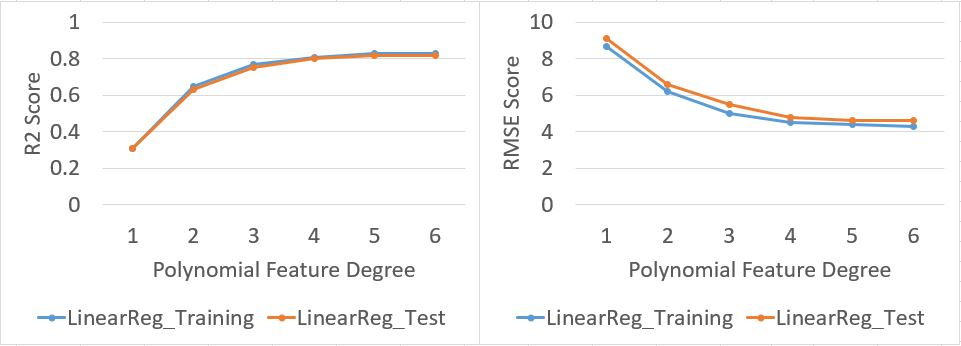


It can be seen that the model performance saturates at degree=4. At this degree, the Linear Regression model has following values: 

    **Training Dataset Accuracy**

    R2-Score -- 0.81 |  RMSE -- 4.5


    **Test Dataset Accuracy**

    R2-Score -- 0.8 |  RMSE -- 4.8
       
     
    
   **This model shows 57% improvement in RMSE value over the baseline model for test dataset**. 


**Impact of adding temperature and rainfall data** --

I found that rainfall and air temperature are partially correlated e.g., rainfall causes air temperature to drop. Also, the rainfall data is quite skewed i.e., only 4% (487/12895) datapoints show > 0 rainfall. So, because of these reasons, I chose not to add rainfall data to the regression model. 

Adding temperature data to the degree = 4 model, the performance changes slightly as shown below.


    **Training Dataset Accuracy**

    R2-Score -- 0.84 |  RMSE -- 4.2


    **Test Dataset Accuracy**

    R2-Score -- 0.8 |  RMSE -- 4.9